In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df = pd.read_csv('data/final_dataset.csv', parse_dates=['order_purchase_timestamp'])

In [18]:
orders = pd.read_csv(
    'data/olist_orders_dataset.csv',
    parse_dates=[
        'order_purchase_timestamp',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ]
)

In [19]:
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')

In [21]:
# Calculating delivery time

orders['delivery_time'] = (
    orders['order_delivered_customer_date'] - 
    orders['order_purchase_timestamp']
).dt.days

# Calculating delivery delay time
orders['delivery_delay'] = (
    orders['order_delivered_customer_date'] - 
    orders['order_estimated_delivery_date']
).dt.days

In [22]:
# Merge review score

delivery_df = orders.merge(
    reviews[['order_id','review_score']],
    on='order_id',
    how='left'
)

# Distribution of delivery delay

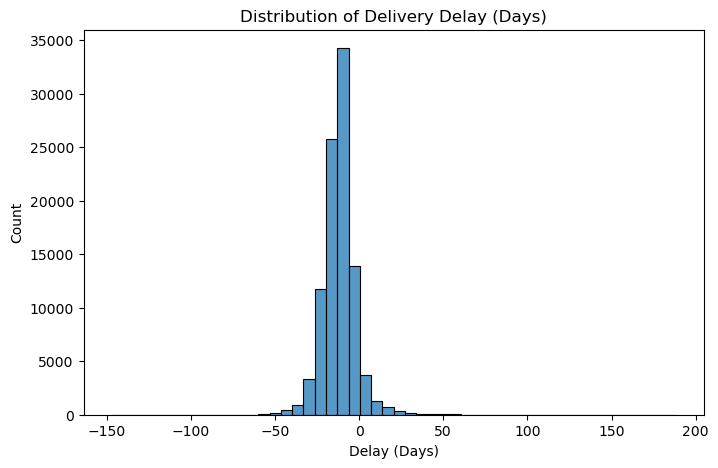

In [24]:
plt.figure(figsize=(8,5))
sns.histplot(delivery_df['delivery_delay'], bins=50)
plt.title('Distribution of Delivery Delay (Days)')
plt.xlabel('Delay (Days)')
plt.ylabel('Count')
plt.show()

The distribution is centered close to 0 days, indicating that most orders were delivered on or near the estimated date.

A slight left skew suggests a significant number of orders were delivered earlier than expected.  

Most deliveries occur within ±10 days of the estimated date, indicating generally reliable logistics performance.

# Review Score vs Delivery Delay

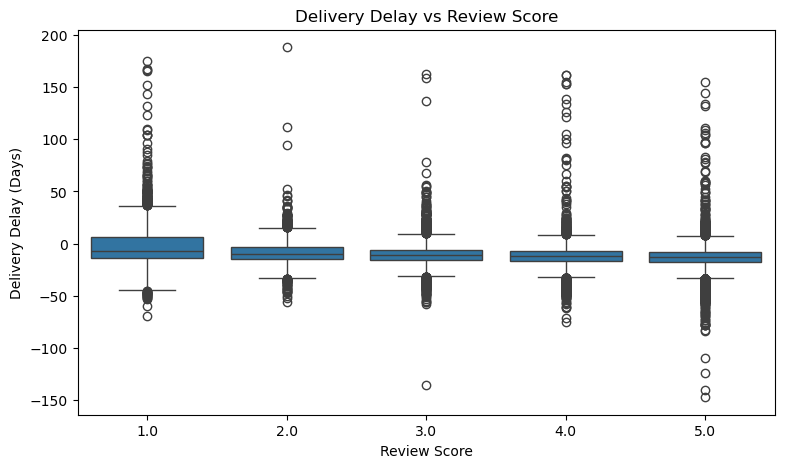

In [26]:
plt.figure(figsize=(9,5))
sns.boxplot(
    x='review_score',
    y='delivery_delay',
    data=delivery_df
)
plt.title('Delivery Delay vs Review Score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Delay (Days)')
plt.show()

Customers with lower review scores (1–2 stars) exhibit higher variability and more extreme positive delivery delays, indicating dissatisfaction linked to late deliveries.

Higher ratings (4–5 stars) show relatively tighter delay distributions, with most deliveries occurring on or before the estimated date.

Although median delay across all ratings is slightly negative (early deliveries), prolonged delays are more concentrated among low-rated orders.

The data indicates a negative relationship between delivery delay and customer review score.

# Average Review Score by Delay Category

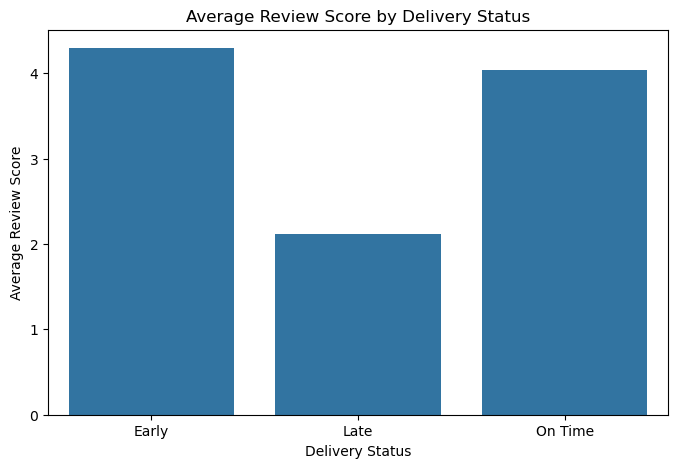

In [29]:
def delay_category(x):
    if x < 0:
        return 'Early'
    elif x == 0:
        return 'On Time'
    else:
        return 'Late'

delivery_df['delay_category'] = delivery_df['delivery_delay'].apply(delay_category)

delay_reviews = delivery_df.groupby('delay_category')['review_score'].mean()

plt.figure(figsize=(8,5))
sns.barplot(x=delay_reviews.index, y=delay_reviews.values)
plt.title('Average Review Score by Delivery Status')
plt.xlabel('Delivery Status')
plt.ylabel('Average Review Score')
plt.show()

Orders delivered early receive the highest average rating (~4.3), followed closely by on-time deliveries (~4.0).

In contrast, late deliveries show a significantly lower average review score (~2.1), indicating a substantial decline in customer satisfaction.

The results demonstrate a clear impact of delivery timeliness on customer perception, with delays strongly associated with negative reviews.

# Monthly Sales Trend Prediction

In [36]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [37]:
order_items = pd.read_csv('data/olist_order_items_dataset.csv')

In [38]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
df = orders.merge(order_items, on='order_id')
df['month'] = df['order_purchase_timestamp'].dt.to_period('M')
monthly_sales = df.groupby('month')['price'].sum().reset_index()
monthly_sales['month_number'] = range(len(monthly_sales))

X = monthly_sales[['month_number']]
y = monthly_sales['price']

model = LinearRegression()
model.fit(X, y)

monthly_sales['predicted_sales'] = model.predict(X)

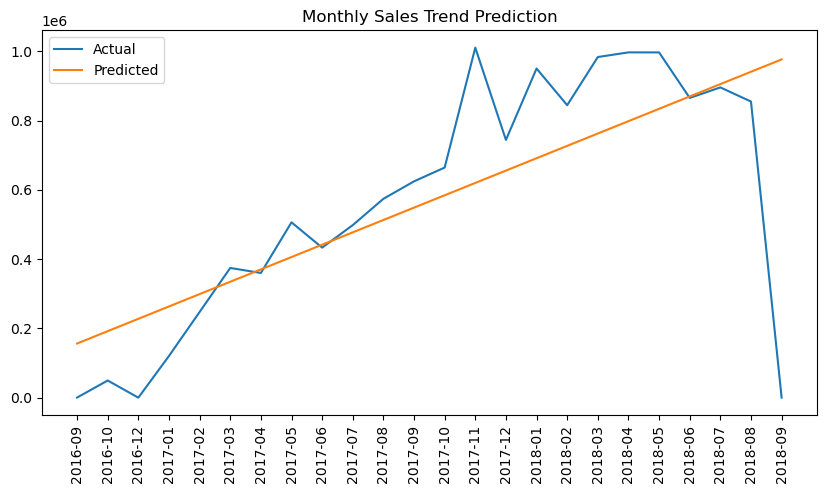

In [39]:
plt.figure(figsize=(10,5))
plt.plot(monthly_sales['month'].astype(str), y, label='Actual')
plt.plot(monthly_sales['month'].astype(str), monthly_sales['predicted_sales'], label='Predicted')
plt.xticks(rotation=90)
plt.legend()
plt.title("Monthly Sales Trend Prediction")
plt.show()

Monthly sales show a strong upward trajectory indicating sustained business growth.

The linear regression forecast suggests continued positive growth momentum in upcoming months.

However, short-term fluctuations indicate potential seasonality and operational variability that may not be fully captured by the linear model.

Overall, the trend reflects a growing and scalable e-commerce operation.

# Evaluation Metrics

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [46]:
# Predictions
y_pred = model.predict(X)

# R (Correlation coefficient)
r = np.corrcoef(y, y_pred)[0, 1]

# R^2
r2 = model.score(X, y)

print("R:", r)
print("R2 Score:", r2)

R: 0.7068680551836148
R2 Score: 0.49966244743906607


Linear Regression model was applied on monthly aggregated sales to identify overall sales trend over time.

0.71 Correlation Coefficient (R). Indicates a strong positive relationship between time and monthly sales.

0.50 R² Score. The model explains approximately 50% of the variance in monthly sales, suggesting a moderate fit.
